# Coursera Course Analysis

## Data preparation

Data downloaded from [Kaggle](https://www.kaggle.com/datasets/siddharthm1698/coursera-course-dataset) website as `coursea_data.csv` file and saved in local folder. For data analysis and visualization we need to set up the environment. First of all we need to import necessary libraries to the notebook and provide special function in the notebook - `%matplotlib inline` With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

Importing libraries for working with data.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm

Set libraries styles

In [2]:
# Set up custom warm palette
custom_palette = sns.color_palette("Blues_r")
sns.set_palette(custom_palette)

# Set up whitegrid
sns.set(style="whitegrid")

# Set up pandas formatting to show full numbers
pd.set_option('float_format', '{:f}'.format)

Now we can import our data to notebook, read it from .csv and convert it to the data frame. Base by dataset provider we know we already have number to identify dataset row, so we can set this column as index number for our rows in data. Setting up data path and loading it to data frame.

In [3]:
data_path = "data/coursea_data.csv"
df = pd.read_csv(data_path, index_col=0)

First check the shape of the data.

In [4]:
df.shape

(891, 6)

From brief view we can see data loaded successfully. It has 891 rows (1 row added for column names) and 6 columns of data with additional 1 column for rows index. Now check what kind of data we have, we can see first few rows of the data, and get the data types of it.

In [5]:
df.head(5)

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.700000,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.700000,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.500000,Mixed,130k
413,A Law Student's Toolkit,Yale University,COURSE,4.700000,Mixed,91k
635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.800000,Mixed,320k


In [6]:
df.dtypes

course_title                 object
course_organization          object
course_Certificate_type      object
course_rating               float64
course_difficulty            object
course_students_enrolled     object
dtype: object

Base by brief view we can see 7 data columns (column 1 is additional index column):
<ol>
    <li># - Provide number to identify dataset. <strong>Data type: object</strong></li>
    <li>course_title - Provide the course title. <strong>Data type: object</strong></li>
    <li>course_organization - Provide organization which conducting the courses.<strong>Data type: object</strong></li>
    <li>course_Certificate_type - Provide details what certification available in courses.<strong>Data type: object</strong></li>
    <li>course_rating - Provide ratings for given course.<strong>Data type: float64</strong></li>
    <li>course_difficulty - Provide information how difficult or what level is the course.<strong>Data type: object</strong></li>
    <li>course_students_enrolled - Provide the number of students that are enrolled in the course.<strong>Data type: object</strong></li>
</ol>

## Data cleaning

Through exploratory data analysis, we aim to identify the most popular course and predict the course that students are most likely to choose.

Before working with data we need to make some adjustments to it, we need to check if there are no missing values, also if there are any duplicate values witch can be removed if necessary, check if column data types are valid for that column.

We can see a problem in column: **course_students_enrolled** it is object type holding numeric and string values, as we do some calculations with numeric values, data type need to be changed, we can fix it by adding new column with converted values in it. For these calculations we create function **convert_with_k witch** check if row value have "k" in the string and multiplies it by 1,000, if value have "m" multiply it by 1,000,000 otherwise just converts it to numeric value. Function provide some security check in column, it will fill "NaN" value to the row if it can't convert it normally.

In [7]:
def convert_with_k(value: float) -> int:
    """
    Convert a numeric value represented as a string with optional 'k' or 'm' suffixes 
    into its corresponding numeric value.

    Parameters: - value (str): The numeric value represented as a string, which may include a 'k' or 'm' suffix.

    Returns: - int: The converted numeric value. If the input value contains 'k', 
    it is multiplied by 1,000, and if it contains 'm', it is multiplied by 1,000,000. 
    If no suffix is present, the original numeric value is returned. 
    If the conversion encounters an error, it returns NaN.
    """
    
    if "k" in str(value):
        return pd.to_numeric(value.replace("k", "")) * 1_000
    elif "m" in str(value):
        return pd.to_numeric(value.replace("m", "")) * 1_000_000
    else:
        return pd.to_numeric(value, errors="coerce") # if errors occurs by converting value, return NaN

As we created new feature **student_count**, we can drop **course_students_enrolled** because it will not be useful anymore.

In [8]:
df["students_count"] = df["course_students_enrolled"].apply(convert_with_k).astype(int)
df = df.drop(columns=["course_students_enrolled"])
df.head().style.hide(axis="index")

course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,students_count
(ISC)² Systems Security Certified Practitioner (SSCP),(ISC)²,SPECIALIZATION,4.700000,Beginner,5300
A Crash Course in Causality: Inferring Causal Effects from Observational Data,University of Pennsylvania,COURSE,4.700000,Intermediate,17000
A Crash Course in Data Science,Johns Hopkins University,COURSE,4.500000,Mixed,130000
A Law Student's Toolkit,Yale University,COURSE,4.700000,Mixed,91000
A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.800000,Mixed,320000


As we can see new column **students_count** was created with converted values in it. Now let's use **isnull** function to check if no NaN values appeared in new column. If function return **True** we need to do additional configuration in function to catch all valid values, if return **False** we can assume all data converted successfully.

In [9]:
df.isnull().any()

course_title               False
course_organization        False
course_Certificate_type    False
course_rating              False
course_difficulty          False
students_count             False
dtype: bool

Function return `False`, lastly we need to check for any duplicate values.

In [10]:
df.duplicated().any()

False

Function returned `False`, now we know there are no duplicates in dataset, we can check data for possible outliers.

In [11]:
df.describe()

,course_rating,students_count
count,891.000000,891.000000
mean,4.677329,90552.076319
std,0.162225,181936.453852
min,3.300000,1500.000000
25%,4.600000,17500.000000
50%,4.700000,42000.000000
75%,4.800000,99500.000000
max,5.000000,3200000.000000


As we can see course_rating looks good, number distribution is not very big and good for analysis, but students_count looks strange, but we know that it show how many students enrolled to course, some course can have few thousands while others can have over few millions, so we consider it as outlier, but we will still explore it as valid data without modifying it.

## Exploratory data analysis

Now we can start exploring the data and make some analysis of it. First let's check how many different data we have in our dataset, for this we can use **nunique** function to get unique values in every column.

In [12]:
df.nunique()

course_title               888
course_organization        154
course_Certificate_type      3
course_rating               14
course_difficulty            4
students_count             205
dtype: int64

Base by unique values some question occurs. Why course title have 888 different values, as we know there are 890 rows, and we check for duplicates and get nothing, so that mean we have some courses with same title but different features, let's check those courses.

In [13]:
df[df["course_title"].duplicated(keep="first") | df["course_title"].duplicated(keep=False)].style.hide(axis="index")

course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,students_count
Developing Your Musicianship,Berklee College of Music,COURSE,4.800000,Mixed,41000
Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.800000,Beginner,54000
Machine Learning,University of Washington,SPECIALIZATION,4.600000,Intermediate,290000
Machine Learning,Stanford University,COURSE,4.900000,Mixed,3200000
Marketing Digital,Universidade de São Paulo,COURSE,4.800000,Beginner,81000
Marketing Digital,Universidad Austral,SPECIALIZATION,4.700000,Beginner,39000


As we assume we have some courses with same title, but as we see courses have different organization, certification type and course difficulty. Other thing we know that some features in our dataset have hundreds of values while others have only few values, like **course_Certificate_type** and **course_difficulty**. For features with low number of unique values we can explore the actual unique values to understand the categories using **unique**.

In [14]:
df["course_Certificate_type"].unique()

array(['SPECIALIZATION', 'COURSE', 'PROFESSIONAL CERTIFICATE'],
      dtype=object)

`course_Certificate_type` - have 3 different types: **SPECIALIZATION**, **COURSE** and **PROFESSIONAL CERTIFICATE**. For this feature lets check the distribution of certificate types.

<AxesSubplot:title={'center':'Distribution Of Certificate types'}, xlabel='Certificate types', ylabel='Count'>

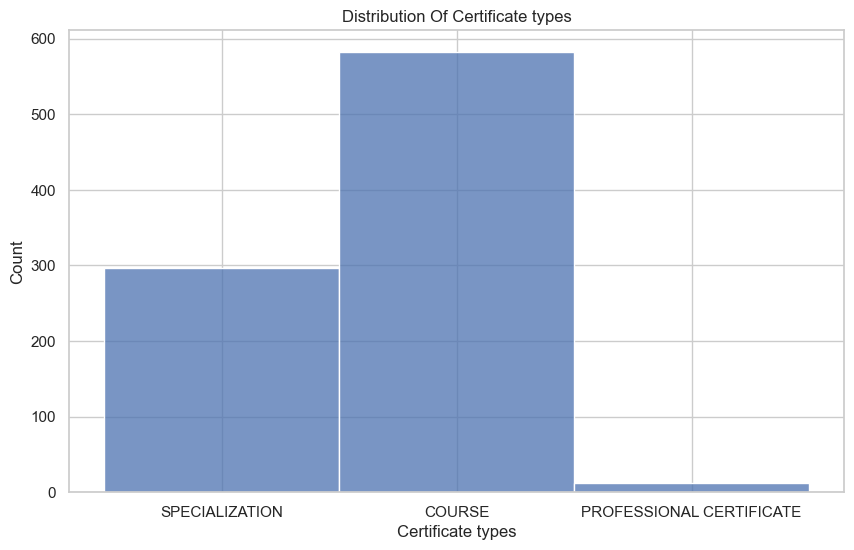

In [15]:
plt.figure(figsize=(10,6))
plt.title("Distribution Of Certificate types")
plt.xlabel("Certificate types")
plt.ylabel("Count")
sns.histplot(data=df, x="course_Certificate_type")

Plot showing that "SPECIALIZATION" and "COURSE" types are dominating over "PROFESSIONAL CERTIFICATE"                            

In [16]:
df["course_difficulty"].unique()

array(['Beginner', 'Intermediate', 'Mixed', 'Advanced'], dtype=object)

`course_difficulty` - have 4 different types: **Beginner**, **Intermediate**, **Mixed** and **Advanced**. For this feature we will plot distribution of difficulty.

<AxesSubplot:title={'center':'Distribution Of Course Difficulty'}, xlabel='Course Difficulty', ylabel='Count'>

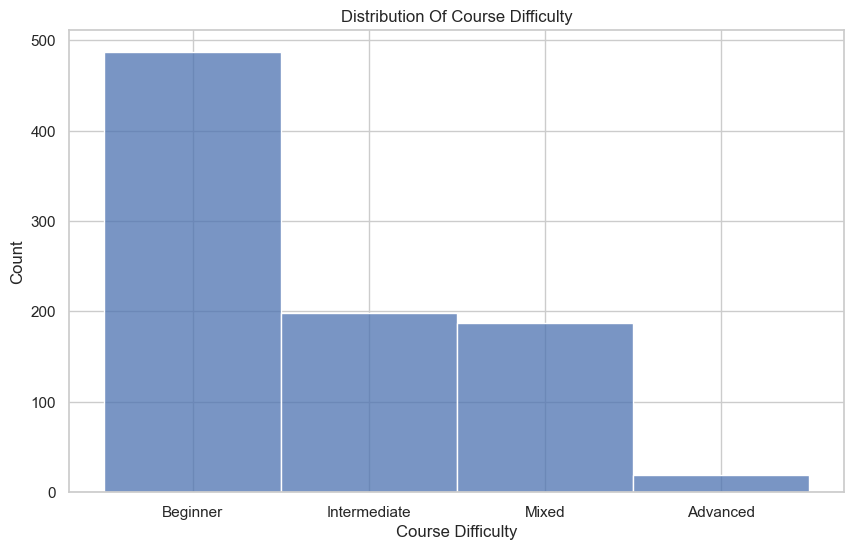

In [17]:
plt.figure(figsize=(10,6))
plt.title("Distribution Of Course Difficulty")
plt.xlabel("Course Difficulty")
plt.ylabel("Count")
sns.histplot(data=df, x="course_difficulty")

This distribution show that "Beginner" course are most popular over all, while "Intermediate" and "Mixed" are both almost the same, and only little piece are for "Advanced" course.

Base by these values we see some groups in our data. We can try to analyse it more deeply. But first we can use **describe** function to get some statistical view of numerical features in our dataset, so we can use combination of different features to find more insigns.

In [18]:
df.describe()

,course_rating,students_count
count,891.000000,891.000000
mean,4.677329,90552.076319
std,0.162225,181936.453852
min,3.300000,1500.000000
25%,4.600000,17500.000000
50%,4.700000,42000.000000
75%,4.800000,99500.000000
max,5.000000,3200000.000000


We can see some information about course ratings and student count. Student count goes from 1.5 thousand to 3.2 million, course rating goes from minimum 3.3 to maximum 5.0, while average of ratings are 4.7, we can plot the course ratings to check the distribution of it.

<AxesSubplot:title={'center':'Distribution Of Course Ratings'}, xlabel='Course Rating', ylabel='Frequency'>

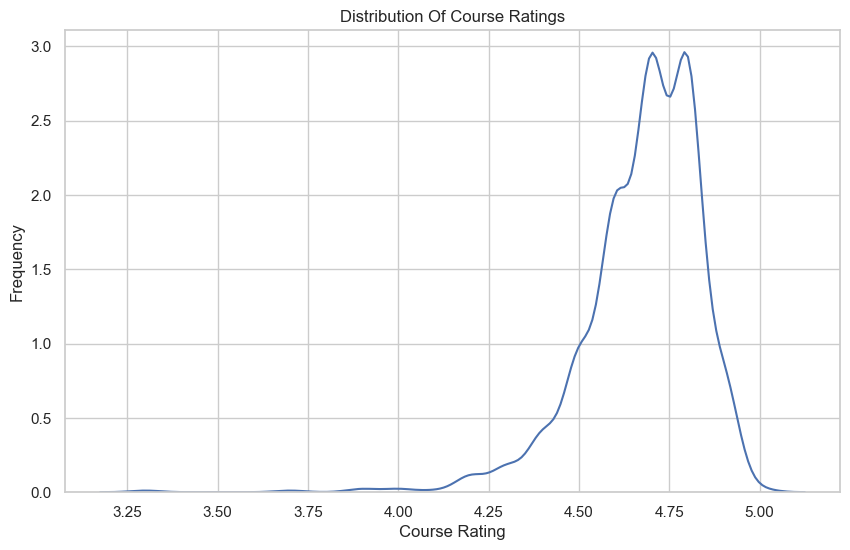

In [19]:
plt.figure(figsize=(10,6))
plt.title("Distribution Of Course Ratings")
plt.xlabel("Course Rating")
plt.ylabel("Frequency")
sns.kdeplot(data=df, x="course_rating")

We can see that courses have high rating, most of them goes from 4.1 to 5.0, people tend to rate course higher than lower. Now let's check distribution of students based on enrollment size.

Text(0.5, 1.0, 'Distribution of Students Based on Enrollment Size')

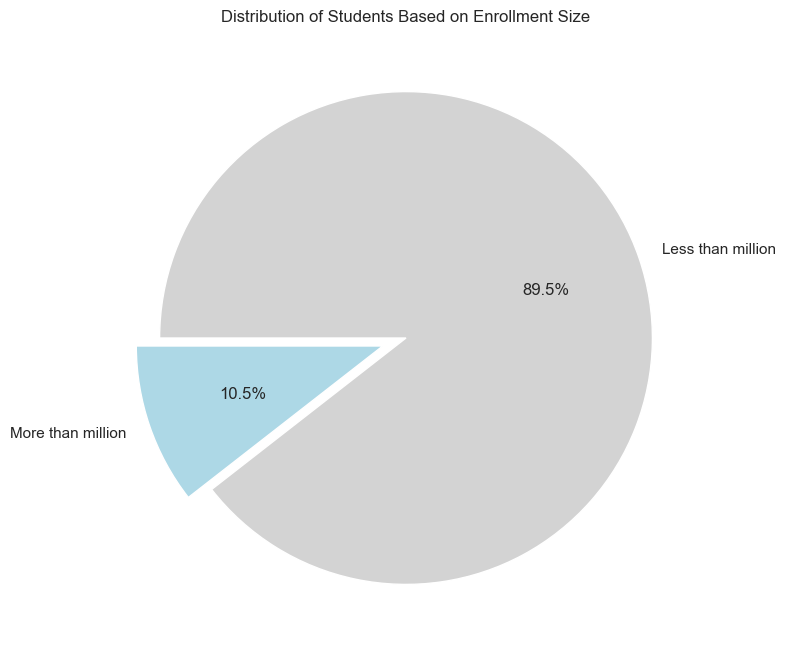

In [20]:
# Splitting data
students_more = df[df["students_count"] >= 1_000_000]["students_count"].sum()
students_less = df[df["students_count"] < 1_000_000]["students_count"].sum()

# Explode slice
explode = [0.1, 0]

# Custom pie colors
pie_colors = ["lightblue", "lightgray"]

# Pie plot
plt.figure(figsize=(8, 8))
plt.pie([students_more, students_less], 
        labels=["More than million", "Less than million"], 
        autopct='%1.1f%%', 
        startangle=180, 
        explode=explode, 
        colors=pie_colors)

# Set up title
plt.title("Distribution of Students Based on Enrollment Size")


From pie chart we find that about 10.5% of students are enrolled in course which have more than a million students in them while 89.5% of students enrolled in less popular courses. Let's find most popular courses.

### TOP 5 most popular courses

As wee know there are some courses with same title, to get the most popular course title we need to join same titles.

Text(0, 0.5, 'Enrolled Students (Million)')

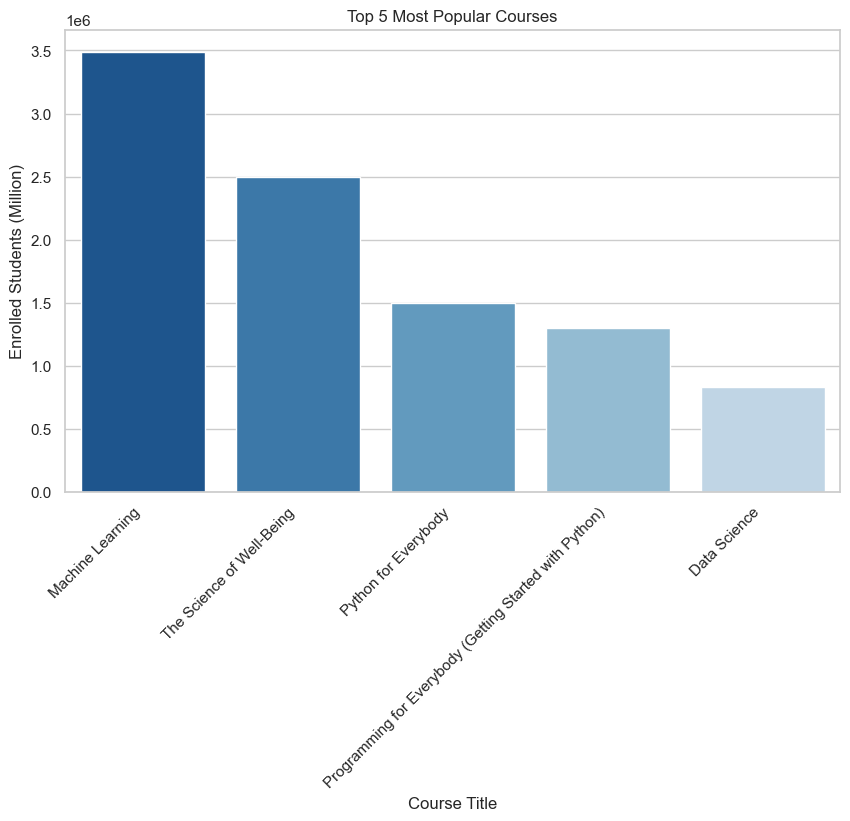

In [21]:
# Group data by title and get top 5 values
grouped_title = df.groupby("course_title", as_index=False)["students_count"].sum()
grouped_title_top_five = grouped_title.sort_values(by=["students_count"],
                                                   ascending=False).head(5)

# Plot barplot
plt.figure(figsize=(10, 6)) # Size
sns.barplot(data=grouped_title_top_five, 
            x="course_title", 
            y="students_count", 
            palette=custom_palette)

# Set up labels
plt.title("Top 5 Most Popular Courses") # Title
plt.xticks(rotation=45, ha="right") # Rotate x Labels by 45 degrees
plt.xlabel("Course Title") # x Label
plt.ylabel("Enrolled Students (Million)") # y Label

In [22]:
# Get exact number of studens in courses
grouped_title_top_five.rename(columns={'course_title': 'Course Title', 
                                       'students_count': 'Total Students'}
                             ).style.hide(axis="index")

Course Title,Total Students
Machine Learning,3490000
The Science of Well-Being,2500000
Python for Everybody,1500000
Programming for Everybody (Getting Started with Python),1300000
Data Science,830000


It appears that **Machine Learning** is top course that students pick. It has almost 3.5 million students enrolled to the course. Second place with 2.5 million students is **The Science of Well-Being**, almost 1 million lower than first place. Third and forth places takes **Python for Everybody** and **Programming for Everybody (Getting Started with Python)** difference between each other is 200 thousand students. Last place with less than a million take "Data Science" course. It can be noted that 4 out of 5 places takes programming.

### TOP 5 organization that are the most popular to study in

To know which organization is most popular over all of them we need to join them and check popularity over students.

Text(0, 0.5, 'Enrolled Students (Million)')

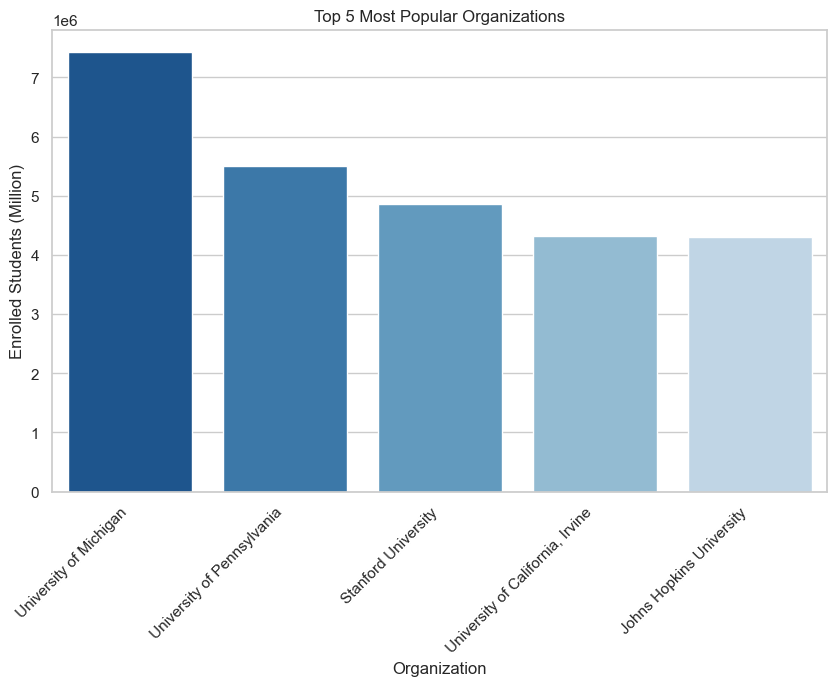

In [23]:
# Group by organization, sort values and get top 5
grouped_by_cert = df.groupby("course_organization", as_index=False)["students_count"].sum()
grouped_by_cert_top = grouped_by_cert.sort_values(by=["students_count"], 
                                                  ascending=False).head(5)

# Plot barplot
plt.figure(figsize=(10, 6)) # Size
sns.barplot(data=grouped_by_cert_top, 
            x="course_organization", 
            y="students_count", 
            palette=custom_palette)

# Set up title and labels
plt.title("Top 5 Most Popular Organizations") # Title
plt.xlabel("Organization") # x label
plt.xticks(rotation=45, ha="right") # Rotate 45 degrees
plt.ylabel("Enrolled Students (Million)") # y Label

In [33]:
grouped_by_cert_top.rename(columns={"course_organization": "Course Organization", 
                                    "students_count": "Students Count"}
                          ).style.hide(axis="index")

Course Organization,Students Count
University of Michigan,7437700
University of Pennsylvania,5501300
Stanford University,4854000
"University of California, Irvine",4326000
Johns Hopkins University,4298900


We find that first place of organization took by **University of Michigan** with more than 7 million students enrolled. In second place sitting **University of Pennsylvania** with 5.5 million. Third place is **Stanford University** with 4.8 million. For fourth place **University of California**, Irvine and fifth place **Johns Hopkins University** we see than both organizations are quite close with average 4.3 million students enrolled in each.

### TOP 1 most popular course based by course difficulty and certification type

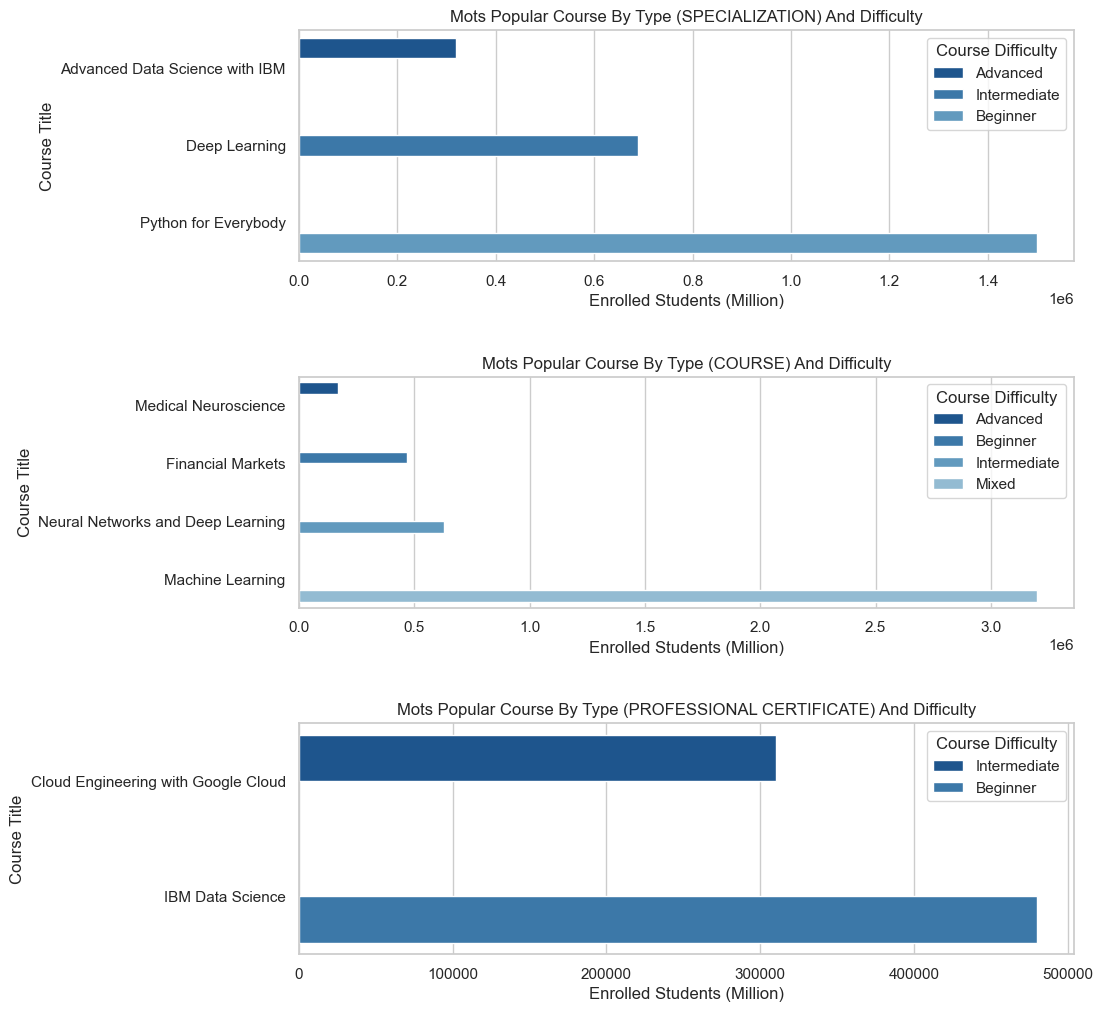

In [25]:
# Group data by title. type, difficulty and sum by student count
grouped_cert_diff = df.groupby(["course_title", 
                                "course_Certificate_type", 
                                "course_difficulty"], as_index=False)["students_count"].sum()

# Get top title using idmax of student count
grouped_cert_diff_top = grouped_cert_diff.loc[grouped_cert_diff.groupby(["course_Certificate_type", 
                                                                          "course_difficulty"])["students_count"].idxmax()]
# Create a figure and 3 rows of subplots
fig, axes = plt.subplots(nrows=3, figsize=(10, 12))

# Certification types
cert_types = list(df["course_Certificate_type"].unique())

# Bar plot loop ploting
for plot_num in range(0, len(cert_types)):
    bar_plot = sns.barplot(
    data=grouped_cert_diff_top
    .where(grouped_cert_diff_top["course_Certificate_type"] == cert_types[plot_num])
    .sort_values(by=["students_count"]), 
    x="students_count", 
    y="course_title", 
    hue="course_difficulty", 
    palette=custom_palette, 
    ax=axes[plot_num])
    
    # Set title and labels
    axes[plot_num].set_title(f"Mots Popular Course By Type ({cert_types[plot_num]}) And Difficulty")
    axes[plot_num].set_xlabel("Enrolled Students (Million)")
    axes[plot_num].set_ylabel("Course Title")
    bar_plot.legend(title="Course Difficulty", loc="upper right")


plt.subplots_adjust(hspace=0.5)

In [26]:
# Group by certification type and students count
sorted_df = grouped_cert_diff_top.sort_values(
    by=["course_Certificate_type", "students_count"], 
    ascending=[True, False])

# Style dataframe by hiding index
styled_df = sorted_df.style.hide(axis="index")

# Display dataframe
styled_df

course_title,course_Certificate_type,course_difficulty,students_count
Machine Learning,COURSE,Mixed,3200000
Neural Networks and Deep Learning,COURSE,Intermediate,630000
Financial Markets,COURSE,Beginner,470000
Medical Neuroscience,COURSE,Advanced,170000
IBM Data Science,PROFESSIONAL CERTIFICATE,Beginner,480000
Cloud Engineering with Google Cloud,PROFESSIONAL CERTIFICATE,Intermediate,310000
Python for Everybody,SPECIALIZATION,Beginner,1500000
Deep Learning,SPECIALIZATION,Intermediate,690000
Advanced Data Science with IBM,SPECIALIZATION,Advanced,320000


It can be noted the popularity distribution of certificate type and course difficulty and the top courses of different aspects. We can see **Machine learning** is the only one course with **Mixed** difficulty over all course types, also it has been observed that **Beginner** difficulty is most popular over course types. It appears students who take courses to be more beginner level.

### Best organizations based by certification type and rating

In [27]:
# Group by organization and type also aggregate course_rating to mean and student_count to sum
grouped_data = df.groupby(["course_organization", 
                          "course_Certificate_type"], as_index=False).agg({"course_rating": "mean",
                                                                          "students_count": "sum"})
# Sort by course_rating and studens_count
grouped_data_sorted = grouped_data.sort_values(["course_rating","students_count"], 
                                               ascending=[False, False])

# Find all top organizations base by type, rating and student count
best_org_types = grouped_data_sorted.groupby("course_Certificate_type").head(1)
best_org_types.style.hide(axis="index")

course_organization,course_Certificate_type,course_rating,students_count
Yonsei University,COURSE,4.900000,520000
Arizona State University,PROFESSIONAL CERTIFICATE,4.900000,150000
Universidade de São Paulo,SPECIALIZATION,4.900000,4500


From a table we can see which organizations have the highest rating over certification type. Base by calculations all organizations have 4.9 rating base by student count.

### Calculate probability using Bayes's Theorem

As we know most popular difficulty is Beginner, given these criteria we can calculate **Baye's Theorem**. We will see that probability is to pick different course type over this difficulty.

Bayes's Theorem P(A|B) = P(B|A)*P(A)/P(B)

Where:
<ol>
    <li>P(A∣B) is the probability of event A given that event B has occurred.</li>
    <li>P(B∣A) is the probability of event B given that event A has occurred.</li>
    <li>P(A) and P(B) are the probabilities of events A and B, respectively.</li>
</ol>

In [28]:
# Calculate probabilities
total_courses = len(df)

# Probability of each certificate type
p_course = len(df[df['course_Certificate_type'] == 'COURSE']) / total_courses
p_specialization = len(df[df['course_Certificate_type'] == 'SPECIALIZATION']) / total_courses
p_professional_certificate = (
    len(df[df['course_Certificate_type'] == 'PROFESSIONAL CERTIFICATE']) / total_courses
)

# Probability of each certificate type given difficulty is 'Beginner'
p_course_given_beginner = (
    len(df[(df['course_Certificate_type'] == 'COURSE') & (df['course_difficulty'] == 'Beginner')]) /
    len(df[df['course_difficulty'] == 'Beginner'])
)
p_specialization_given_beginner = (
    len(df[(df['course_Certificate_type'] == 'SPECIALIZATION') & (df['course_difficulty'] == 'Beginner')]) /
    len(df[df['course_difficulty'] == 'Beginner'])
)
p_professional_certificate_given_beginner = (
    len(df[(df['course_Certificate_type'] == 'PROFESSIONAL CERTIFICATE') & (df['course_difficulty'] == 'Beginner')]) /
    len(df[df['course_difficulty'] == 'Beginner'])
)

print(f"P(COURSE | Beginner) = {p_course_given_beginner}")
print(f"P(SPECIALIZATION | Beginner) = {p_specialization_given_beginner}")
print(f"P(PROFESSIONAL CERTIFICATE | Beginner) = {p_professional_certificate_given_beginner}")

P(COURSE | Beginner) = 0.5790554414784395
P(SPECIALIZATION | Beginner) = 0.4024640657084189
P(PROFESSIONAL CERTIFICATE | Beginner) = 0.018480492813141684


- P("COURSE" | "Beginner") 
- P("SPECIALIZATION" | "Beginner")
- ("PROFESSIONAL CERTIFICATE" | "Beginner")


are the probabilities that a course belongs to each category given that it has a "Beginner" difficulty level.

As we can see, if the student chose randomly one course probability to pick **COURSE** type and **Beginner** difficulty is 58%.

### Analyse data using Simpson's paradox

Simpson's Paradox is a statistical phenomenon in which trends can appear in several groups of data but can disappear then groups are combined. For briew view let's analyze course ratings grouped by certificate types and difficulty.

In [29]:
# Get average ratings for certification types
avg_ratings_by_certificate = df.groupby('course_Certificate_type')['course_rating'].mean()

# Calculate average ratings for all difficulty levels
avg_ratings_by_difficulty = df.groupby('course_difficulty')['course_rating'].mean()

Average Ratings by Certificate Type

In [30]:
avg_ratings_by_certificate

course_Certificate_type
COURSE                     4.707045
PROFESSIONAL CERTIFICATE   4.700000
SPECIALIZATION             4.618182
Name: course_rating, dtype: float64

Average Ratings by Difficulty Level

In [31]:
avg_ratings_by_difficulty

course_difficulty
Advanced       4.600000
Beginner       4.680903
Intermediate   4.646465
Mixed          4.708556
Name: course_rating, dtype: float64

We can see that "COURSE" type have bigger rating over other types. Also the "Mixed" difficulty is have higher ratings over others. But then we combine these data we can see different trend of Overall Average Rating:

In [32]:
overall_avg_rating = df['course_rating'].mean()
overall_avg_rating

4.6773288439955065

We see that overall rating is different from each calculated average ratings for certification types and difficulty levels. This is how Simpson's Paradox work, groups of data can differ on different group level.

## Summary 

Overall **COURSE** certification type is the most popular, as we can understand **COURSE** can take lowest time to complete, students tend to finish it faster, by difficulty they pick **Beginner**, so we can assume students with less or no experience pick courses which are easy and fast to finish. Base by ratings students evaluate them quite well, most of the ratings goes from 4.1 to 5.0. Also we saw that courses with over million students enrollment size takes big place in our data with 10.5% over all courses. We found most popular organizations, the top one is **University of Michigan** with more than 7 million students enrolled. As displayed before we saw that courses about **Machine Learning**, **Data Science** and **Python** are most popular and appear more often than others so we assume that most popular courses is programming, 4 out of 5 top courses are base on programming. As evidence by using **Baye's Theorem** we check that probability to take **Course** which is **Beginner** level is about 58%.

## Suggestions for Improvement

- **Machine Learning Models:** If possible use MLM models to investigate data for predictive analysis, classification, etc. Models can help achieve new insights of data.
- **More data features:** Having more columns to pick from will help to analyse differently over genders, course price or course length. Wee could make different approach to our data, it will give more confidence over it.